# Data Pre-processing and Exploratory Data Analysis

In [1]:
import sys
sys.path.append('../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot  as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
AUTOTUNE = tf.data.experimental.AUTOTUNE

import IPython.display as display
from PIL import Image
import os

import glob
from pathlib import Path

print(tf.__version__)
print(keras.__version__)

2.12.0
2.12.0


In [2]:
dataset_main = pd.read_csv("../data/raw/data_labels_mainData.csv")
dataset_main = pd.read_csv("../data/raw/data_labels_mainData.csv")

In [3]:
dataset_main.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0


In [4]:
print(dataset_main.isna().sum())

InstanceID      0
patientID       0
ImageName       0
cellTypeName    0
cellType        0
isCancerous     0
dtype: int64


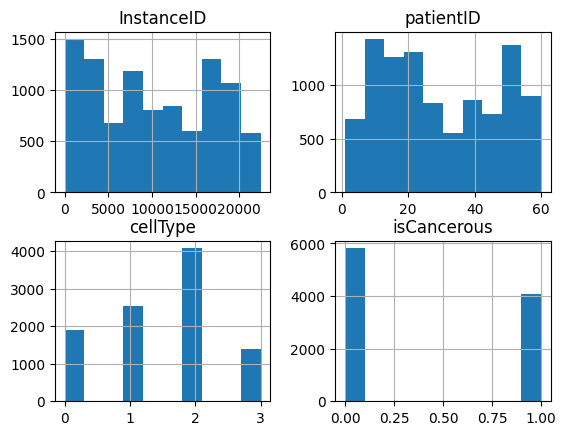

In [5]:
dataset_main.hist()
plt.show()

In [6]:
instances_per_patient = dataset_main.groupby('patientID').size()
print(instances_per_patient)

patientID
1      19
2      33
3     136
4     127
5     169
6     198
7     253
8     332
9     348
10    302
11     56
12    130
13    180
14    207
15    125
16    111
17    310
18    320
19    158
20    325
21    224
22    152
23    254
24    192
25    180
26    157
27     17
28     15
29    355
30    110
31    137
32     99
33    163
34     14
35     11
36    128
37     71
38     84
39    105
40    209
41    250
42    136
43    137
44    121
45     74
46    120
47    133
48    147
49    187
50    195
51    286
52    178
53    132
54    389
55    263
56     92
57    149
58    161
59    115
60    115
dtype: int64


In [7]:
instances_per_cellType = dataset_main.groupby('cellType').size()
print(instances_per_cellType)

cellType
0    1888
1    2543
2    4079
3    1386
dtype: int64


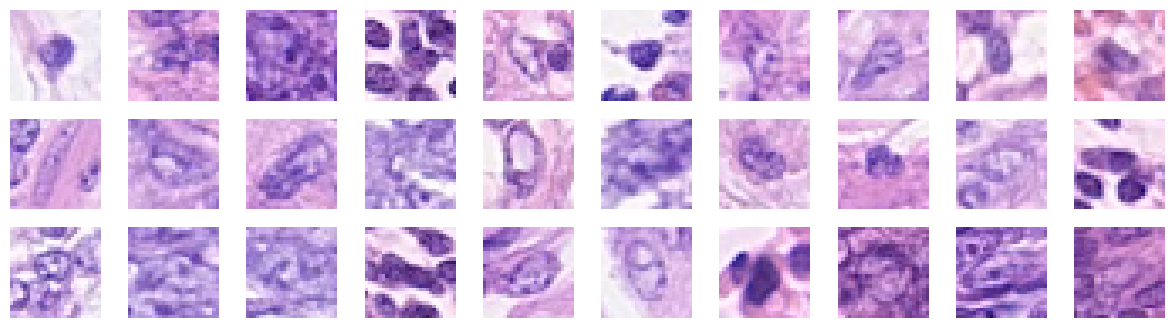

In [8]:
image_folder = "../data/raw/patch_images"
image_paths = [os.path.join(image_folder, filename) for filename in os.listdir(image_folder)]
rand_paths = np.random.choice(image_paths, 30)

plt.figure(figsize=(15,4))
for i, image_path in enumerate(rand_paths):
    im = np.asarray(Image.open(image_path))
    plt.subplot(3,10,i+1)
    plt.imshow(im,cmap='gray')
    plt.axis('off')
    
plt.show()

# Image Pre-processing

## Grayscale conversion + Normalization

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_image = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_image = ImageDataGenerator(rescale=1./255, data_format='channels_last')

dataset_main['isCancerous'] = dataset_main['isCancerous'].astype('str')

batch_size = 27

img_generator = train_image.flow_from_dataframe(
        dataframe=dataset_main,
        directory='../data/raw/patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical', 
        seed=0,
        color_mode='rgb')

dataset_main['isCancerous'] = dataset_main['isCancerous'].astype('int')



Found 9896 validated image filenames belonging to 2 classes.


## Exploratory Data Analysis

In [10]:
dataset_non_cancerous = dataset_main[dataset_main["isCancerous"]==0]
dataset_cancerous = dataset_main[dataset_main["isCancerous"]==1]

In [11]:
dataset_non_cancerous

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0
...,...,...,...,...,...,...
9838,1566,60,1566.png,inflammatory,1,0
9839,1568,60,1568.png,inflammatory,1,0
9840,1569,60,1569.png,inflammatory,1,0
9841,1570,60,1570.png,inflammatory,1,0


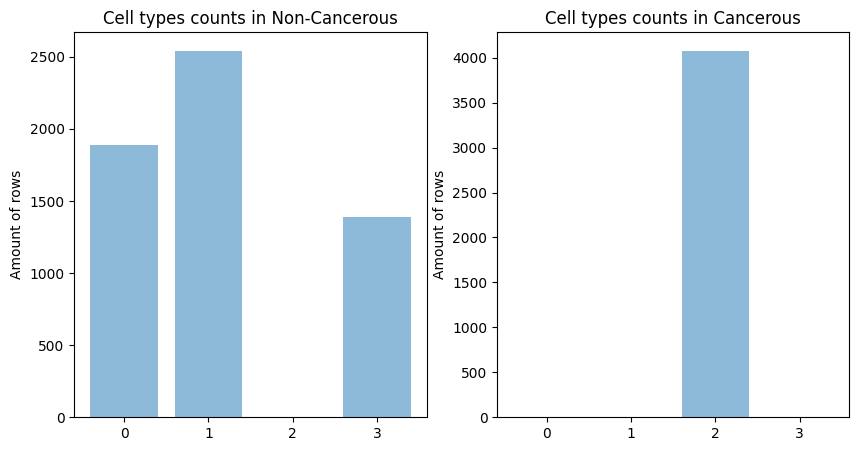

In [12]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
y_pos = list(set(dataset_main["cellType"]))
x_pos = [len(dataset_non_cancerous[dataset_non_cancerous["cellType"]==i]) for i in y_pos]
plt.bar(y_pos, x_pos, align='center', alpha=0.5)
plt.xticks(y_pos, y_pos)
plt.ylabel('Amount of rows')
plt.title('Cell types counts in Non-Cancerous')

plt.subplot(1, 2, 2)
x_pos = [len(dataset_cancerous[dataset_cancerous["cellType"]==i]) for i in y_pos]
plt.bar(y_pos, x_pos, align='center', alpha=0.5)
plt.xticks(y_pos, y_pos)
plt.ylabel('Amount of rows')
plt.title('Cell types counts in Cancerous')
plt.show()

Text(0.5, 1.0, 'cancer instances per patient')

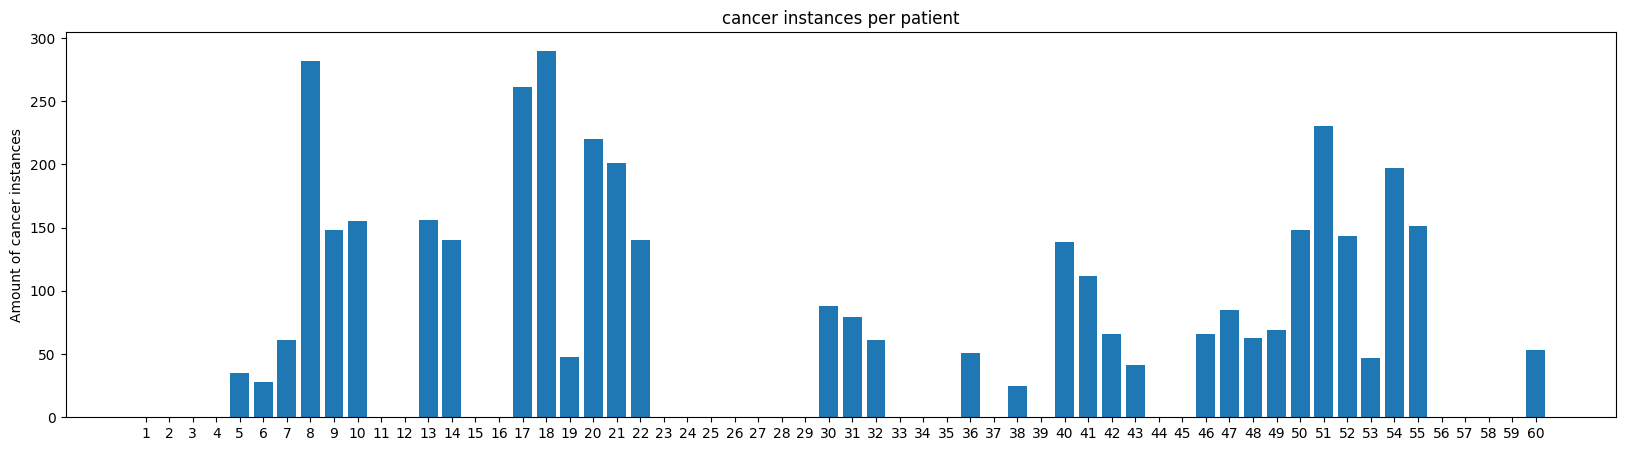

In [13]:
plt.figure(figsize=(20, 5))
y_pos = list(set(dataset_main["patientID"]))
x_pos = [len(dataset_main.loc[(dataset_main["patientID"]==i) & (dataset_main["isCancerous"]==1)]) for i in y_pos]
plt.bar(y_pos, x_pos, align='center', alpha=1)
plt.xticks(y_pos, y_pos)
plt.ylabel('Amount of cancer instances')
plt.title('cancer instances per patient')

In [14]:
len(dataset_main.loc[(dataset_main["patientID"]==5) & (dataset_main["cellType"]==0)])

25

Text(0.5, 1.0, 'Cells by cell type per patient')

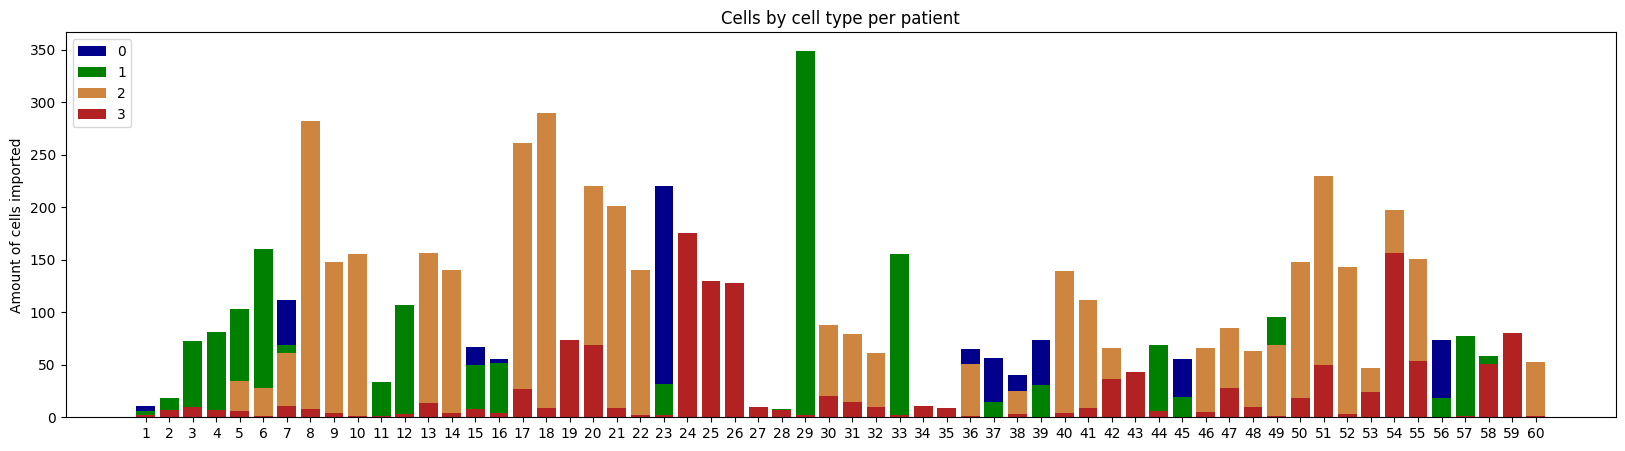

In [18]:
plt.figure(figsize=(20, 5))
y_pos = list(set(dataset_main["patientID"]))
x_pos = [len(dataset_main.loc[(dataset_main["patientID"]==i) & (dataset_main["cellType"]==0)]) for i in y_pos]
x_pos2 = [len(dataset_main.loc[(dataset_main["patientID"]==i) & (dataset_main["cellType"]==1)]) for i in y_pos]
x_pos3 = [len(dataset_main.loc[(dataset_main["patientID"]==i) & (dataset_main["cellType"]==2)]) for i in y_pos]
x_pos4 = [len(dataset_main.loc[(dataset_main["patientID"]==i) & (dataset_main["cellType"]==3)]) for i in y_pos]
plt.bar(y_pos, x_pos, align='center', alpha=1, color='darkblue')
plt.bar(y_pos, x_pos2, align='center', alpha=1, color='green')
plt.bar(y_pos, x_pos3, align='center', alpha=1, color='peru')
plt.bar(y_pos, x_pos4, align='center', alpha=1, color='firebrick')
plt.xticks(y_pos, y_pos)
plt.ylabel('Amount of cells imported')
plt.legend(list(set(dataset_main["cellType"])), loc='upper left')
plt.title('Cells by cell type per patient')